In [1]:


from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import models, transforms

In [2]:


if torch.cuda.is_available():  
    device = torch.device("cuda")
    print(f"Using GPU device: {torch.cuda.get_device_name(device)}\n")
else:  
    device = torch.device("cpu")
    print("Using CPU.\n")

Using CPU.



In [3]:


labels_path = Path(r"C:\Users\karin\veo_nu\Data\Initial_combined_labels.csv")  
labels_df = pd.read_csv(labels_path)  
display(labels_df.head())  

,Frame,Possession,Set piece
0,410,1,0
1,420,1,0
2,430,1,0
3,440,1,0
4,450,1,0


In [4]:
Y = labels_df[["Possession", "Set piece"]].values  
Y = torch.from_numpy(Y).float().to(device)  
print(Y.shape)  
N, n_classes = Y.shape[0], Y.shape[1]  

torch.Size([680, 2])


In [5]:


frames_path = Path(r"C:\Users\karin\veo_nu\data\initial_combined_frames")  
n_channels, height, width = 3, 224, 224  
X = torch.empty((N, n_channels, height, width))  
print(X.shape) 

torch.Size([680, 3, 224, 224])


In [6]:


for i, file in enumerate(frames_path.glob("*.png")):  
    with Image.open(file).convert("RGB") as img:  
        to_tensor = transforms.ToTensor()
        resize = transforms.Resize((height, width))  
        img_tensor = to_tensor(img).float()  
        img_tensor = resize(img_tensor) 
        X[i, :] = img_tensor  

In [7]:

dataset = TensorDataset(X, Y)
train_data, val_data = random_split(dataset, [0.90, 0.10])

print(train_data[:][0].shape, train_data[:][1].shape, val_data[:][0].shape, val_data[:][1].shape)


torch.Size([612, 3, 224, 224]) torch.Size([612, 2]) torch.Size([68, 3, 224, 224]) torch.Size([68, 2])


In [8]:


def apply_gradient_centralization(optimizer):
    
    
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                # Compute the mean of the gradient
                grad_mean = param.grad.data.mean(dim=tuple(range(1, len(param.grad.shape))), keepdim=True)
                # Centralize the gradient
                param.grad.data -= grad_mean

In [9]:

def train(
    model: nn.Module,  
    train_loader: DataLoader, 
    val_loader: DataLoader,  
    optimizer: optim,  
    loss_fn: nn.modules.loss,  
    max_epochs: int = 5,  
    val_check_interval: int = 10, 
) -> tuple[torch.Tensor, np.ndarray, np.ndarray]:  
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    train_losses, val_losses = [], []  

    
    for epoch in range(max_epochs):
        for batch_i, (x_train, y_train) in enumerate(train_loader):
            model.train() 
            optimizer.zero_grad()  
            out = model(x_train.to(device))  
            loss = loss_fn(out, y_train.to(device))  
            loss.backward()  
            apply_gradient_centralization(optimizer)  
            optimizer.step()  
           
            if batch_i % val_check_interval == 0: 
                train_losses.append(loss.item()) 
                model.eval()  
                with torch.no_grad(): 
                    x_val, y_val = next(iter(val_loader)) 
                    val_out = model(x_val.to(device))
                    val_loss = loss_fn(val_out, y_val.to(device)) 
                    val_losses.append(val_loss.item()) 
                print( 
                    f"Epoch {epoch + 1}: Batch {batch_i + 1}:  "
                    f"Loss = {train_losses[-1]:.3f}, Val Loss = {val_losses[-1]:.3f}"
                )
            
   
    print("Finished training:")
    print(f"Epoch {epoch + 1}:  Batch {batch_i + 1}: Loss = {train_losses[-1]:.3f}, Val Loss = {val_losses[-1]:.3f}")
    return loss, train_losses, val_losses

In [10]:

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
print(model)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:


dropout_rate = 0.2  
model.classifier = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.classifier.in_features, n_classes),
    nn.Sigmoid()  
)

In [12]:

batch_size = 32  
lr = 0.02  

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-7, momentum=0.6, nesterov=True)

loss, train_losses, val_losses = train(
    model.to(device), train_loader, val_loader, optimizer, loss_fn, max_epochs=2, val_check_interval=3
)

Epoch 1: Batch 1:  Loss = 0.521, Val Loss = 0.547
Epoch 1: Batch 4:  Loss = 0.393, Val Loss = 0.449
Epoch 1: Batch 7:  Loss = 0.332, Val Loss = 0.428
Epoch 1: Batch 10:  Loss = 0.450, Val Loss = 0.417
Epoch 1: Batch 13:  Loss = 0.411, Val Loss = 0.448
Epoch 1: Batch 16:  Loss = 0.468, Val Loss = 0.434
Epoch 1: Batch 19:  Loss = 0.345, Val Loss = 0.580
Epoch 2: Batch 1:  Loss = 0.426, Val Loss = 0.578
Epoch 2: Batch 4:  Loss = 0.397, Val Loss = 0.509
Epoch 2: Batch 7:  Loss = 0.342, Val Loss = 0.725
Epoch 2: Batch 10:  Loss = 0.462, Val Loss = 1.377
Epoch 2: Batch 13:  Loss = 0.424, Val Loss = 2.581
Epoch 2: Batch 16:  Loss = 0.500, Val Loss = 27.420
Epoch 2: Batch 19:  Loss = 0.341, Val Loss = 28.125
Finished training:
Epoch 2:  Batch 20: Loss = 0.341, Val Loss = 28.125


Text(0.5, 1.0, 'Training and Validation Losses')

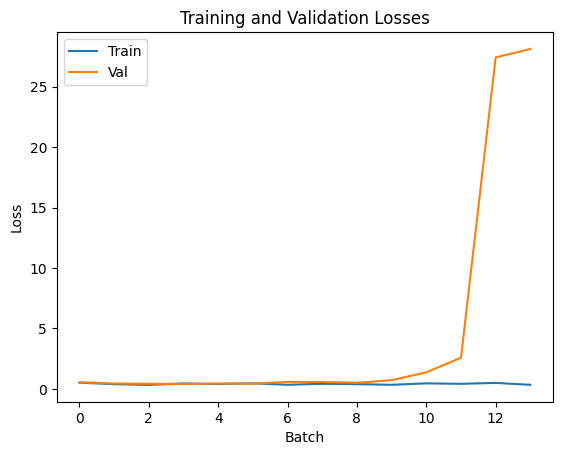

In [13]:


fig, ax = plt.subplots()
ax.plot(train_losses, label="Train")
ax.plot(val_losses, label="Val")
ax.legend()
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Losses")


In [15]:
# Save model
model_path = f"MatchMentor_Liverpool_Loss={train_losses[-1]:.3f}_ValLoss={val_losses[-1]:.3f}.pth"
save_path = Path.cwd().parent / "models" / model_path
torch.save(model.state_dict(), save_path)

In [16]:
dummy_input = torch.randn(1, 3, 224, 224)  # Example for a model expecting 224x224 RGB images
# Export the model
torch.onnx.export(model, dummy_input, "model.onnx", verbose=True)

OnnxExporterError: Module onnx is not installed!

In [ ]:
# View val images and see how it performed

val_frame = val_data[:][0][2].unsqueeze(0)  # shape of first val image

In [ ]:
model.eval()
model(val_frame.to(device))

In [ ]:
val_data[:][1][0]

In [ ]:
_20.round()

In [ ]:
transforms.ToPILImage()(val_frame[0]).resize((640, 360))